# Project 1

### Question 1
Estimate σ by computing the standard deviation of the EFFR changes. Report your estimate as a percent.

In [1]:
import pandas as pd

# Load the data file
data = pd.ExcelFile("Project 2.xlsx")

# Parse the first sheet of the Excel file
df = data.parse("Sheet1")

# Calculate the daily changes in the EFFR
df["EFFR_Change"] = df["EFFR"].diff()

# Compute the standard deviation of the EFFR changes to estimate σ
sigma = df["EFFR_Change"].std()

# Convert the standard deviation to a percentage
sigma_percent = sigma * 100

# Print the result
print(f" σ is: {sigma_percent:.2f}%")


 σ is: 168.88%


### Question 2
Estimate κ and θ by minimizing the sum of squares of the difference between the zero-coupon yield predicted by the model and the observed zero-coupon yield. Your each year, you will use the corresponding EFFR as a proxy for rt. Report the RMSE of your estimation and comment on whether the errors are significant or not.

In [2]:
import numpy as np
from scipy.optimize import minimize

# Vasicek model for zero-coupon yields
def vasicek_yield(maturities, r, kappa, theta, sigma):
    """
    maturities: array-like, time to maturity in years
    r: float, current short-term interest rate
    kappa: float, mean-reverting coefficient
    theta: float, long-run interest rate
    sigma: float, volatility of interest rate changes
    """
    xi = (1 - np.exp(-kappa * maturities)) / (kappa * maturities)
    yield_curve = theta * (1 - xi) - (sigma**2 / (2 * kappa**2)) * (1 - 2 * xi + xi**2) + xi * r
    return yield_curve

# Loss function for optimization
def loss_function(params, maturities, observed_yields, short_rates):
    """
    params: list of [kappa, theta]
    maturities: array-like, time to maturity in years
    observed_yields: 2D array, observed zero-coupon yields for all years
    short_rates: 1D array, short-term interest rates (EFFR) for all years
    """
    kappa, theta = params
    sigma = observed_yields.std()
    total_loss = 0
    for i in range(len(short_rates)):
        modeled_yields = vasicek_yield(maturities, short_rates[i], kappa, theta, sigma)
        total_loss += np.sum((observed_yields[i, :] - modeled_yields)**2)
    return total_loss

# Extract maturities and data for all years
maturities = np.array([1, 5, 10, 20, 30])
observed_yields = df[["Y01", "Y05", "Y10", "Y20", "Y30"]].values
short_rates = df["EFFR"].values

# Initial guess for kappa and theta
initial_guess = [0.1, 5.0]

# Minimize the loss function using all data
result = minimize(loss_function, initial_guess, args=(maturities, observed_yields, short_rates), bounds=[(0.01, 2), (0, 10)])

# Optimal parameters
kappa_opt, theta_opt = result.x

# Compute RMSE
sigma_est = observed_yields.std()
rmse = np.sqrt(np.mean([
    np.sum((observed_yields[i, :] - vasicek_yield(maturities, short_rates[i], kappa_opt, theta_opt, sigma_est))**2)
    for i in range(len(short_rates))
]))

# Print results
print(f"Estimated κ (kappa): {kappa_opt:.4f}")
print(f"Estimated θ (theta): {theta_opt:.4f}")
print(f"RMSE: {rmse:.4f}")


Estimated κ (kappa): 0.7291
Estimated θ (theta): 5.7079
RMSE: 2.5641


In [3]:
from scipy.stats import ttest_1samp

# Calculate the residuals
residuals = observed_yields.flatten() - np.array([
    vasicek_yield(maturities, short_rates[i], kappa_opt, theta_opt, sigma_est)
    for i in range(len(short_rates))
]).flatten()

# Perform t-test
t_stat, p_value = ttest_1samp(residuals, 0)

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Determine the significance
if p_value < 0.05:
    print("The residuals are significantly different from zero. The model may not fit well.")
else:
    print("The residuals are not significantly different from zero. The model fits well.")


T-statistic: -1.4730
P-value: 0.1433
The residuals are not significantly different from zero. The model fits well.


### Question 3
For each of the years 2000, 2003, 2007, 2013, 2021 and 2023, generate a plot of the term-structure of zero-coupon yields predicted by the model as a function of maturity from 0 to 30 years. For each year, include the observed yields, and comment on how the model captures the observed term-structure of interest rates. In which year(s) the model struggles fitting the term-structure the most?

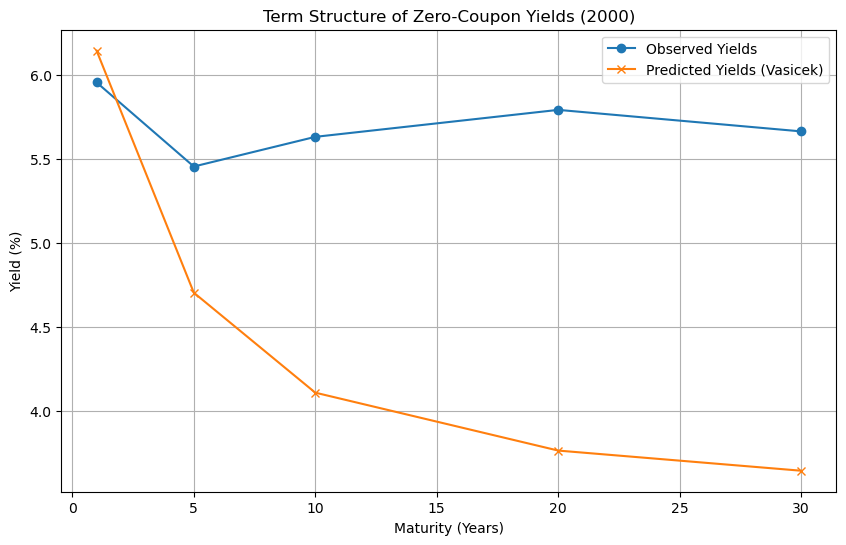

Year: 2000
Residuals (Observed - Predicted): [-0.18927284  0.75258622  1.52625863  2.03269987  2.02451595]
Mean Absolute Residual for 2000: 1.3051


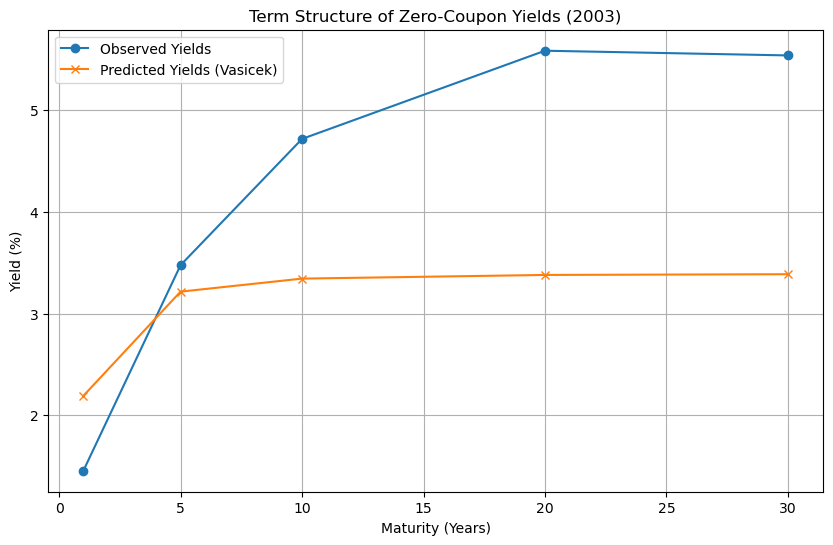

Year: 2003
Residuals (Observed - Predicted): [-0.73572172  0.26004974  1.37191378  2.20228719  2.14892861]
Mean Absolute Residual for 2003: 1.3438


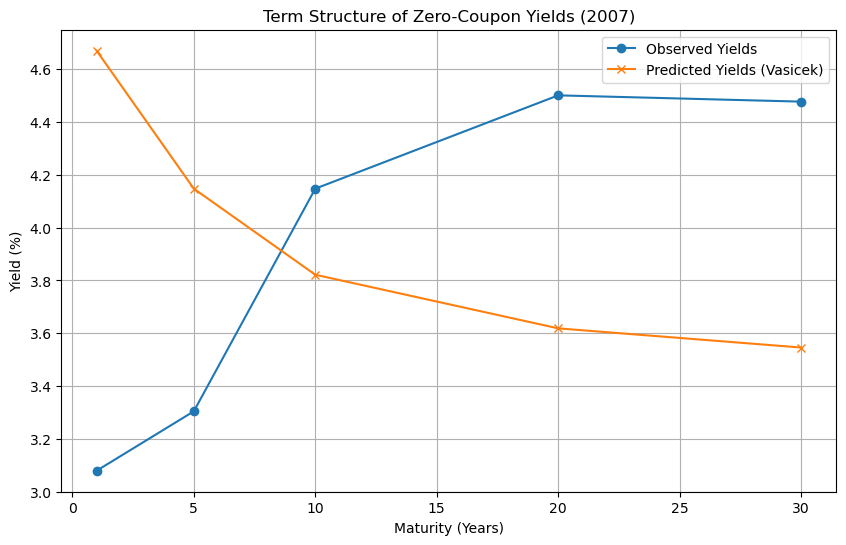

Year: 2007
Residuals (Observed - Predicted): [-1.59062117 -0.84321944  0.32595687  0.88244568  0.93126752]
Mean Absolute Residual for 2007: 0.9147


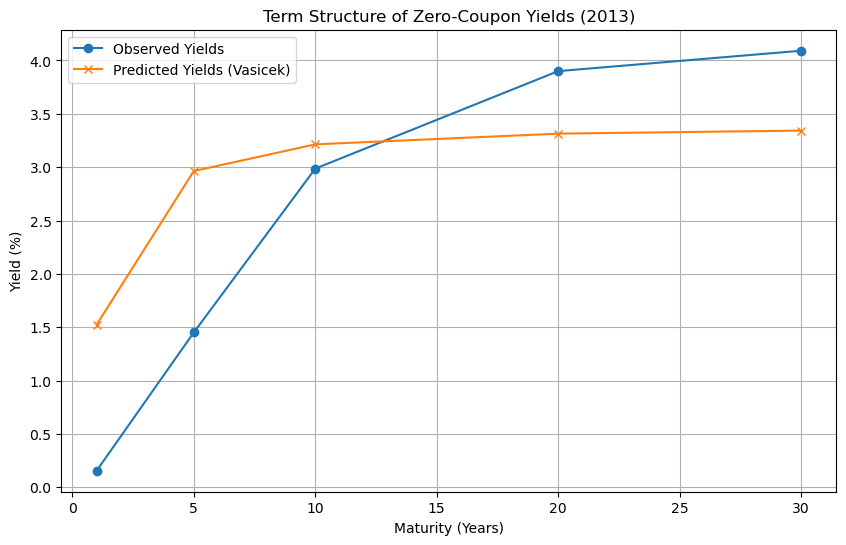

Year: 2013
Residuals (Observed - Predicted): [-1.36902187 -1.51242504 -0.2273451   0.58585167  0.74840495]
Mean Absolute Residual for 2013: 0.8886


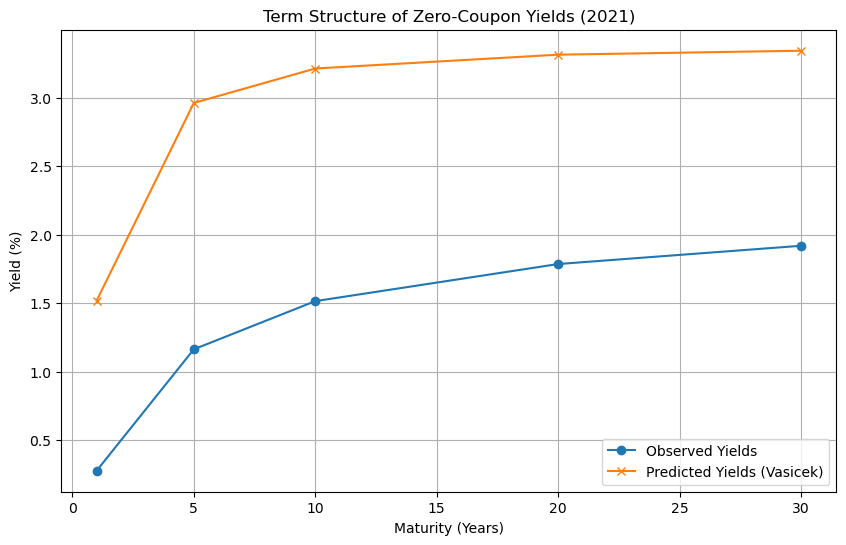

Year: 2021
Residuals (Observed - Predicted): [-1.24172187 -1.79895349 -1.69877445 -1.52876254 -1.42433786]
Mean Absolute Residual for 2021: 1.5385


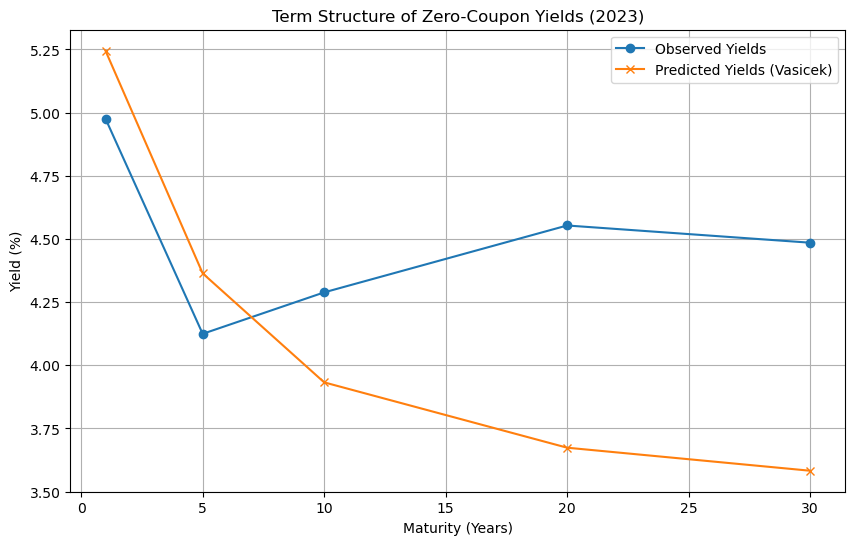

Year: 2023
Residuals (Observed - Predicted): [-0.26892104 -0.23931457  0.35613421  0.8793965   0.90243472]
Mean Absolute Residual for 2023: 0.5292


In [5]:
import matplotlib.pyplot as plt

# Define the years to analyze
years_to_analyze = [2000, 2003, 2007, 2013, 2021, 2023]

# Define the maturities corresponding to the yields
maturities = np.array([1, 5, 10, 20, 30])  # Maturities in years

# Loop through each specified year
for year in years_to_analyze:
    # Filter the data for the current year
    year_data = df[df['Date'].dt.year == year]
    if year_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Extract observed yields and short rate for the year
    observed_yields = year_data[["Y01", "Y05", "Y10", "Y20", "Y30"]].values[0]  # Relevant columns only
    short_rate = year_data.iloc[0]["EFFR"]

    # Calculate predicted yields using the Vasicek model
    predicted_yields = vasicek_yield(maturities, short_rate, kappa_opt, theta_opt, sigma_est)

    # Plot observed vs predicted yields
    plt.figure(figsize=(10, 6))
    plt.plot(maturities, observed_yields, label="Observed Yields", marker='o')
    plt.plot(maturities, predicted_yields, label="Predicted Yields (Vasicek)", marker='x')
    plt.title(f"Term Structure of Zero-Coupon Yields ({year})")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Yield (%)")
    plt.legend()
    plt.grid()
    plt.show()

    # Compare model performance
    residuals = observed_yields - predicted_yields
    print(f"Year: {year}")
    print(f"Residuals (Observed - Predicted): {residuals}")
    print(f"Mean Absolute Residual for {year}: {np.mean(np.abs(residuals)):.4f}")


### Question 4
For the year 2024, generate a plot of the instantaneous futures and forward rates as a function of maturity from 0 to 30 years.

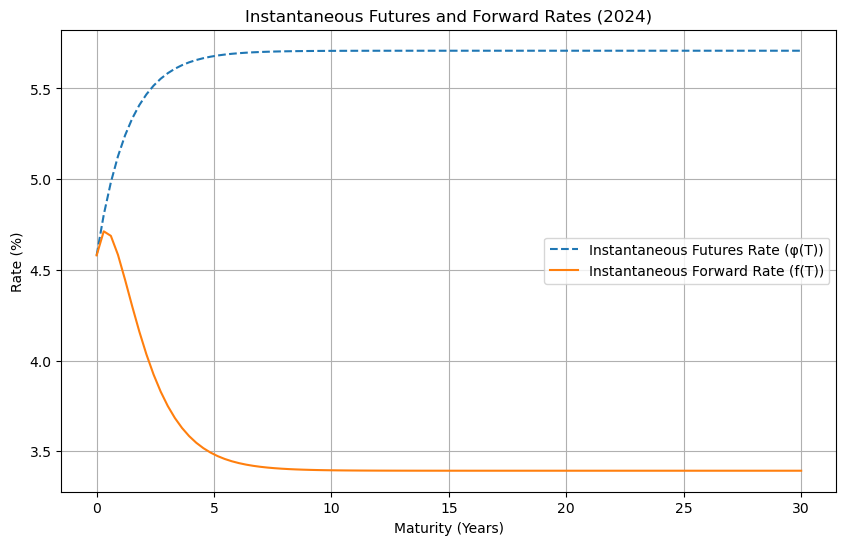

In [6]:
# Define the function for instantaneous futures rate
def futures_rate(maturities, r, kappa, theta):
    """
    Calculate instantaneous futures rate based on Vasicek model.
    """
    phi = theta * (1 - np.exp(-kappa * maturities)) + np.exp(-kappa * maturities) * r
    return phi

# Define the function for forward rate
def forward_rate(maturities, r, kappa, theta, sigma):
    """
    Calculate forward rate based on Vasicek model.
    """
    phi = futures_rate(maturities, r, kappa, theta)
    correction = (sigma**2 / (2 * kappa**2)) * (1 - np.exp(-kappa * maturities))**2
    return phi - correction

# Parameters for the Vasicek model
maturities = np.linspace(0, 30, 100)  # Maturities from 0 to 30 years
r_2024 = df[df['Date'].dt.year == 2024]['EFFR'].mean() if not df[df['Date'].dt.year == 2024].empty else 0  # Short rate for 2024

# Calculate futures and forward rates
futures = futures_rate(maturities, r_2024, kappa_opt, theta_opt)
forward = forward_rate(maturities, r_2024, kappa_opt, theta_opt, sigma_est)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(maturities, futures, label="Instantaneous Futures Rate (φ(T))", linestyle='--')
plt.plot(maturities, forward, label="Instantaneous Forward Rate (f(T))", linestyle='-')
plt.title("Instantaneous Futures and Forward Rates (2024)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate (%)")
plt.legend()
plt.grid()
plt.show()


### Question 5
Using the parameters estimated before, and the short-rate as of 11/22/2024, generate a graph of the probability density function of the instantaneous risk-free rate in 1, 5, 20 and 30 years from now.

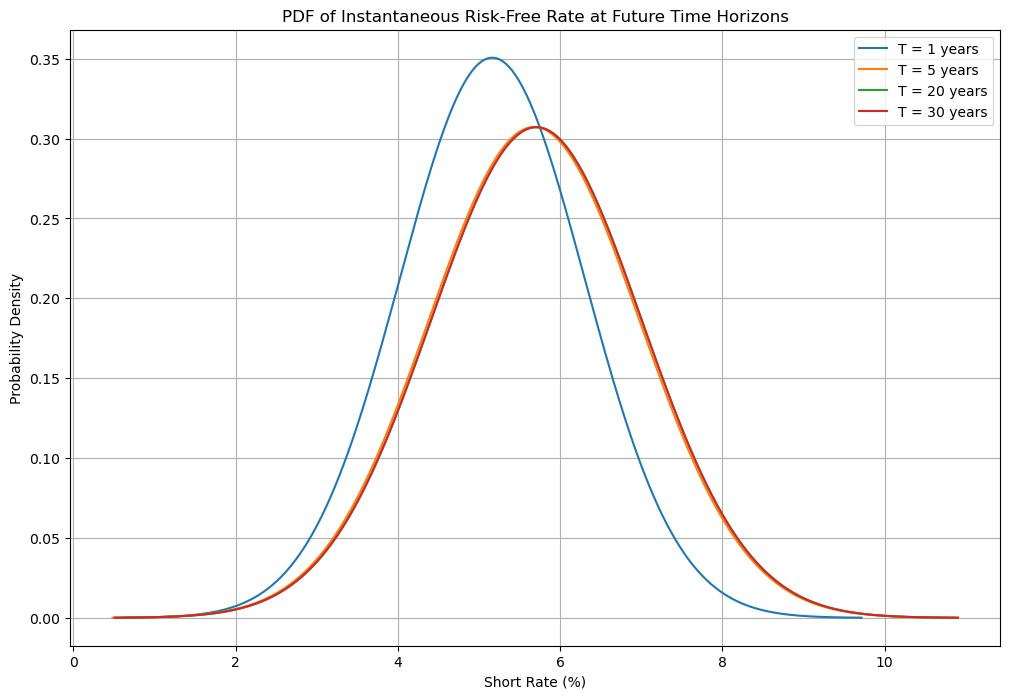

In [7]:
from scipy.stats import norm

# Function to calculate mean and variance of r(T)
def vasicek_mean_variance(r0, kappa, theta, sigma, T):
    """
    Calculate the mean and variance of the instantaneous risk-free rate at time T.
    
    r0: initial short rate
    kappa: mean-reverting coefficient
    theta: long-term mean rate
    sigma: volatility of the short rate
    T: time horizon in years
    """
    mean = r0 * np.exp(-kappa * T) + theta * (1 - np.exp(-kappa * T))
    variance = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * T))
    return mean, variance

# Time horizons to analyze
time_horizons = [1, 5, 20, 30]

# Initial short rate (use the most recent EFFR value)
r0 = df["EFFR"].iloc[-1]

# Prepare the plot
plt.figure(figsize=(12, 8))

# Generate and plot PDF for each time horizon
for T in time_horizons:
    mean, variance = vasicek_mean_variance(r0, kappa_opt, theta_opt, sigma_est, T)
    std_dev = np.sqrt(variance)
    
    # Generate x values for the PDF (around the mean ± 4 std deviations)
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 500)
    pdf = norm.pdf(x, loc=mean, scale=std_dev)  # Generate the PDF
    
    # Plot the PDF
    plt.plot(x, pdf, label=f"T = {T} years")

# Finalize the plot
plt.title("PDF of Instantaneous Risk-Free Rate at Future Time Horizons")
plt.xlabel("Short Rate (%)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()
